Importing The Neccessary Libraries

In [52]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from PIL import Image
import random

Reading the Artist names and all their info to extract the important features to use in our image preprocessing

In [25]:
df = pd.read_csv('Artist_data/artists.csv')
df.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

Sorting data by the number of painting each artist have (taken >150 paintings artists only to have a better model accuracy and less computational power)
the new class weight feature is used to  put weight on paintings to tell us the importance of each (will be used in the model to show the significance of each artist)

In [26]:
artists = df.sort_values(by=['paintings'], ascending=False)
artists_top = df[df['paintings'] >= 150].reset_index(drop=True)
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top = artists_top.sort_values(by='paintings', ascending=False).reset_index(drop=True)
artists_top = artists_top[['name', 'paintings', 'class_weight']]
class_weights = artists_top['class_weight'].to_dict()
print(f"{artists_top}\n\n{class_weights}")

                     name  paintings  class_weight
0        Vincent van Gogh        877      0.353224
1             Edgar Degas        702      0.441279
2           Pablo Picasso        439      0.705644
3   Pierre-Auguste Renoir        336      0.921958
4          Albrecht Dürer        328      0.944444
5            Paul Gauguin        311      0.996070
6          Francisco Goya        291      1.064528
7               Rembrandt        262      1.182358
8           Alfred Sisley        259      1.196053
9                  Titian        255      1.214815
10           Marc Chagall        239      1.296141
11          Rene Magritte        194      1.596793
12      Amedeo Modigliani        193      1.605066
13              Paul Klee        188      1.647754
14          Henri Matisse        186      1.665472
15            Andy Warhol        181      1.711479
16         Mikhail Vrubel        171      1.811566
17      Sandro Botticelli        164      1.888889

{0: 0.3532243760293931, 1: 0.4

In [27]:
# Function to show if the directories exist with the top artist names chosen (to see if names are correct)
def Directories_Exist(artists_top_name, image_folder):
    for name in artists_top_name:
        if os.path.exists(os.path.join(image_folder, name)):
            print("Found -->", os.path.join(image_folder, name))
        else:
            print("Did not find -->", os.path.join(image_folder, name))

In [28]:
image_folder = 'Artist_data/images/images'
artists_top_name = artists_top['name'].str.replace(' ', '_').values
# See if all directories exist
Directories_Exist(artists_top_name, image_folder)

Found --> Artist_data/images/images\Vincent_van_Gogh
Found --> Artist_data/images/images\Edgar_Degas
Found --> Artist_data/images/images\Pablo_Picasso
Found --> Artist_data/images/images\Pierre-Auguste_Renoir
Did not find --> Artist_data/images/images\Albrecht_Dürer
Found --> Artist_data/images/images\Paul_Gauguin
Found --> Artist_data/images/images\Francisco_Goya
Found --> Artist_data/images/images\Rembrandt
Found --> Artist_data/images/images\Alfred_Sisley
Found --> Artist_data/images/images\Titian
Found --> Artist_data/images/images\Marc_Chagall
Found --> Artist_data/images/images\Rene_Magritte
Found --> Artist_data/images/images\Amedeo_Modigliani
Found --> Artist_data/images/images\Paul_Klee
Found --> Artist_data/images/images\Henri_Matisse
Found --> Artist_data/images/images\Andy_Warhol
Found --> Artist_data/images/images\Mikhail_Vrubel
Found --> Artist_data/images/images\Sandro_Botticelli


changing this artist name since his name is different in the directory

In [29]:
updated_name = "Albrecht_Du╠êrer"
artists_top.iloc[4, 0] = updated_name
artists_top.iloc[4, 0]

'Albrecht_Du╠êrer'

Now every thing is good

In [50]:
artists_top_name = artists_top['name'].str.replace(' ', '_').values
Directories_Exist(artists_top_name, image_folder)

Found --> Artist_data/images/images\Vincent_van_Gogh
Found --> Artist_data/images/images\Edgar_Degas
Found --> Artist_data/images/images\Pablo_Picasso
Found --> Artist_data/images/images\Pierre-Auguste_Renoir
Found --> Artist_data/images/images\Albrecht_Du╠êrer
Found --> Artist_data/images/images\Paul_Gauguin
Found --> Artist_data/images/images\Francisco_Goya
Found --> Artist_data/images/images\Rembrandt
Found --> Artist_data/images/images\Alfred_Sisley
Found --> Artist_data/images/images\Titian
Found --> Artist_data/images/images\Marc_Chagall
Found --> Artist_data/images/images\Rene_Magritte
Found --> Artist_data/images/images\Amedeo_Modigliani
Found --> Artist_data/images/images\Paul_Klee
Found --> Artist_data/images/images\Henri_Matisse
Found --> Artist_data/images/images\Andy_Warhol
Found --> Artist_data/images/images\Mikhail_Vrubel
Found --> Artist_data/images/images\Sandro_Botticelli


Visualizing a random Art-Piece from each artist

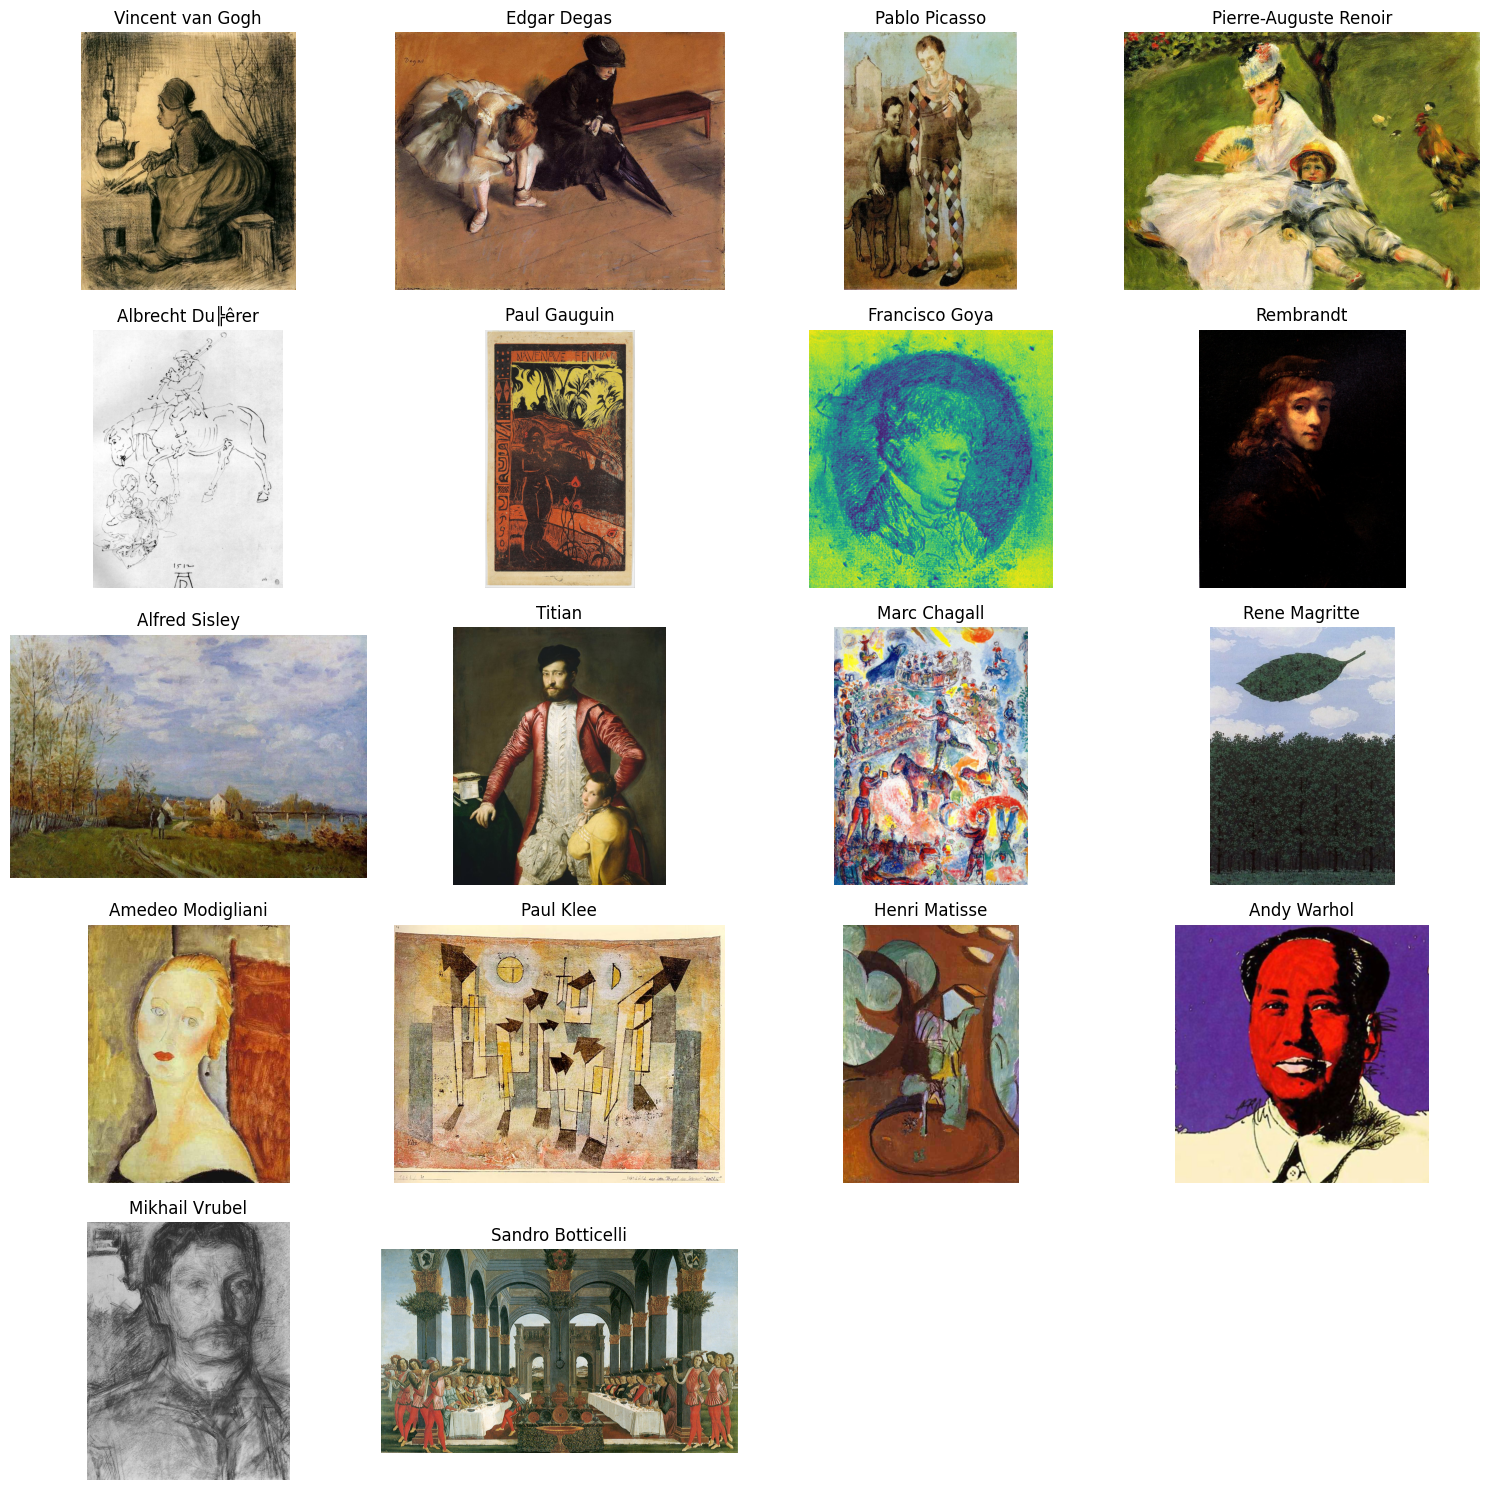

In [53]:

# Plot an image for each artist
plt.figure(figsize=(15, 15))
for i, artist in enumerate(artists_top_name, 1):
    # Construct image path
    image_path = os.path.join(image_folder, artist)
    # Get a list of image files for the artist
    image_files = os.listdir(image_path)
    # Select a random image file
    if image_files:
        random_image_file = random.choice(image_files)
        random_image_path = os.path.join(image_path, random_image_file)
        # Load and plot the image
        image = Image.open(random_image_path)
        plt.subplot(5, 4, i)
        plt.imshow(image)
        plt.title(artist.replace('_', ' '))
        plt.axis('off')

plt.tight_layout()
plt.show()

Data Augmentation and converting images to arrays of pixels ( to be able to train)

In [34]:
# Initializing some variables to help in the image data generators
batch_size = 32
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)
# num_classes = len(os.listdir(image_folder)) 
num_classes = len(artists_top_name)
# creating an ImageDataGenerator to augment images
train_datagen = ImageDataGenerator(
    rescale=1.0/255, # rescaling the pixel values to [0,1]
    rotation_range=20, # rotating images in the range ( 0 to 20 degrees)
    width_shift_range=0.2, # horizontal shift the image to the left or right
    height_shift_range=0.2, # vertical shift the image to the left or right
    shear_range=0.2, # shear transformation in the range [0, 0.2]
    zoom_range=0.2, # zooming inside pictures by up to 20%
    horizontal_flip=True, # flipping images horizontally
    fill_mode='nearest', # a strategy for filling in pixels apear after a rotation or shift 
    validation_split=0.2  # splitting data into 80% training and 20% validation (to test)
)

# creating train and validation generators to preprocess images directly to the models
train_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=artists_top_name.tolist()
)

validation_generator = train_datagen.flow_from_directory(
    image_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    classes=artists_top_name.tolist()
)


Found 4469 images belonging to 18 classes.
Found 1107 images belonging to 18 classes.


Visualizing the augmentation effects on a sample image

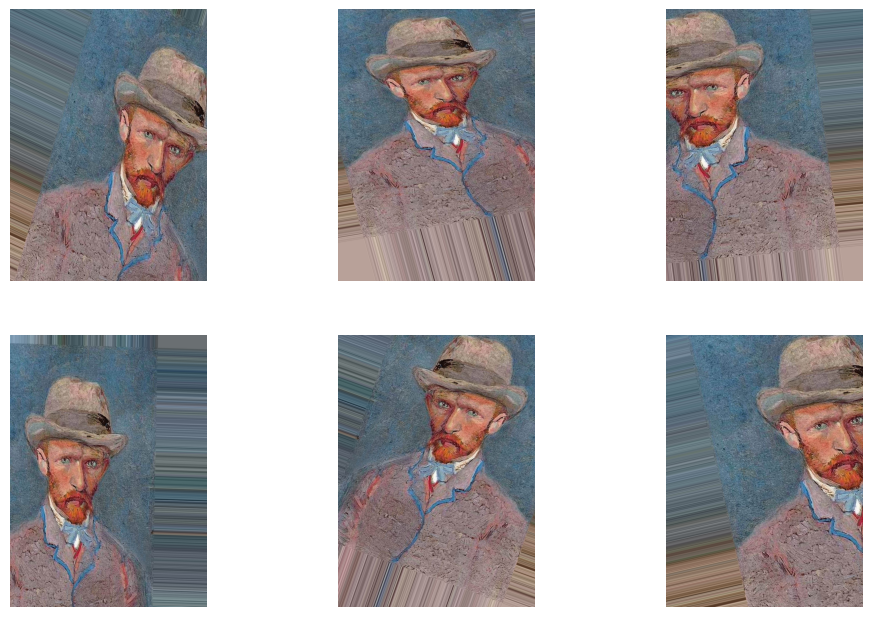

In [54]:
# loading a sample image
sample_image_path = 'Artist_data/images/images/Vincent_van_Gogh/Vincent_van_Gogh_52.jpg' 
sample_image = load_img(sample_image_path)  # Load the image
sample_image_array = img_to_array(sample_image)  # Convert image to array
sample_image_array = np.expand_dims(sample_image_array, axis=0)  # Add batch dimension

# generating an augmented samples
augmented_samples = train_datagen.flow(sample_image_array, batch_size=1)

# visualizing the augmented images
plt.figure(figsize=(12, 12))
for i in range(6): 
    plt.subplot(3, 3, i + 1)
    augmented_image = next(augmented_samples)[0]
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()        

### Resnet50 Pretrained Model

Finetuning the full-network of the pretrained model with the newly added layers first

In [41]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [42]:

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(32, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(num_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

initializing the optimizer of the model (Adam) to compile the model

In [43]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

Callbacks (Early Stop and Learning rate reduction)

In [44]:
early_stop_1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='auto', restore_best_weights=True)
early_stop_2 = EarlyStopping(monitor='val_loss', patience=15, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

training first the full network

In [21]:
Resnet_history1 = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=20,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop_1],
                              class_weight=class_weights
                             )

Epoch 1/20


W0000 00:00:1717080426.442728     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/140 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step - accuracy: 0.1521 - loss: 2.8160

W0000 00:00:1717080559.171746     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.1535 - loss: 2.8105

W0000 00:00:1717080566.564544     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717080601.247431     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.1540 - loss: 2.8086 - val_accuracy: 0.0325 - val_loss: 4.8569 - learning_rate: 1.0000e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - accuracy: 0.3740 - loss: 2.1196 - val_accuracy: 0.0379 - val_loss: 3.6881 - learning_rate: 1.0000e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 112s 767ms/step - accuracy: 0.4963 - loss: 1.7861 - val_accuracy: 0.0289 - val_loss: 2.9300 - learning_rate: 1.0000e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 110s 756ms/step - accuracy: 0.5681 - loss: 1.6402 - val_accuracy: 0.0668 - val_loss: 3.0327 - learning_rate: 1.0000e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 142s 761ms/step - accuracy: 0.6173 - loss: 1.5367 - val_accuracy: 0.1680 - val_loss: 2.8398 - learning_rate: 1.0000e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 763ms/step - accuracy: 0.6685 - loss: 1.3796 - val_accuracy: 0.2502 - val_loss: 2.5872 - learning_rate: 1.0000e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 112s 768ms/ste

freezing the core resnetlayers and training only the first 50 layers of the Resnet models (benefiting from the pre-trained weights and learned features of the base model). This approach helps balance the adaptation to the new task (Artist Art-Pieces images) with the preservation of valuable pre-trained features.

In [22]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

Resnet_history2 = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop_2],
                              class_weight=class_weights
                             )

Epoch 1/50


W0000 00:00:1717082785.442034     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/140 ━━━━━━━━━━━━━━━━━━━━ 1:23 889ms/step - accuracy: 0.9135 - loss: 0.5079

W0000 00:00:1717082825.525180     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9134 - loss: 0.5010

W0000 00:00:1717082886.004391     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717082907.977551     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 154s 886ms/step - accuracy: 0.9134 - loss: 0.5009 - val_accuracy: 0.7787 - val_loss: 0.9786 - learning_rate: 1.0000e-04
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 765ms/step - accuracy: 0.9268 - loss: 0.4634 - val_accuracy: 0.7940 - val_loss: 0.9030 - learning_rate: 1.0000e-04
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 751ms/step - accuracy: 0.9215 - loss: 0.4406 - val_accuracy: 0.8094 - val_loss: 0.8788 - learning_rate: 1.0000e-04
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 110s 757ms/step - accuracy: 0.9293 - loss: 0.4152 - val_accuracy: 0.8112 - val_loss: 0.8405 - learning_rate: 1.0000e-04
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 746ms/step - accuracy: 0.9373 - loss: 0.3932 - val_accuracy: 0.7778 - val_loss: 0.9509 - learning_rate: 1.0000e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 109s 747ms/step - accuracy: 0.9311 - loss: 0.4079 - val_accuracy: 0.8022 - val_loss: 0.8382 - learning_rate: 1.0000e-04
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 110s 752ms/

Visualizing Classification report and Confusion matrix to show the model performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1717088256.045899     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

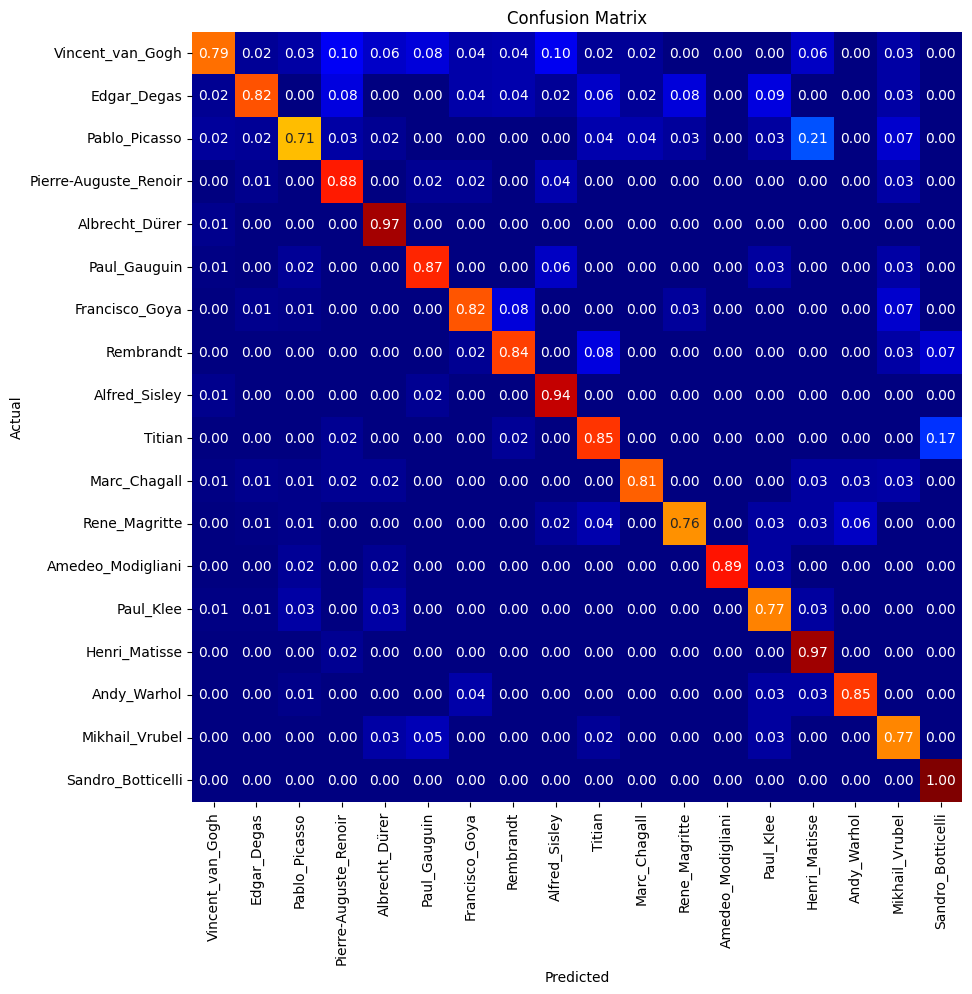

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.90      0.79      0.84       167
          Edgar_Degas       0.89      0.82      0.85       135
        Pablo_Picasso       0.81      0.71      0.76        86
Pierre-Auguste_Renoir       0.76      0.88      0.82        59
      Albrecht_Dürer       0.85      0.97      0.90        63
         Paul_Gauguin       0.84      0.87      0.86        62
       Francisco_Goya       0.85      0.82      0.83        55
            Rembrandt       0.82      0.84      0.83        50
        Alfred_Sisley       0.80      0.94      0.86        50
               Titian       0.76      0.85      0.80        48
         Marc_Chagall       0.90      0.81      0.85        47
        Rene_Magritte       0.85      0.76      0.80        37
    Amedeo_Modigliani       1.00      0.89      0.94        36
            Paul_Klee       0.75      0.77      0.76        35
        Henri_Matisse       0.7

In [23]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(33):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(num_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, validation_generator)

Saving the model in a h5 file in order to deploy it in the app

In [25]:
model.save('model/Artist_Resnet_model_0.84.h5')

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

def read_csv(csv_path):
    return pd.read_csv(csv_path)

def sort_artist_paintings_above_150(df):
    artists = df.sort_values(by=['paintings'], ascending=False)
    artists_top = df[df['paintings'] >= 150].reset_index(drop=True)
    return artists_top

def class_weights_dict(artists_top):
    artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
    artists_top = artists_top.sort_values(by='paintings', ascending=False).reset_index(drop=True)
    artists_top = artists_top[['name', 'paintings', 'class_weight']]
    class_weights = artists_top['class_weight'].to_dict()
    return class_weights

def get_artist_names(artists_top):
    artists_top_name = artists_top['name'].str.replace(' ', '_').values
    return artists_top_name

def update_class_name(updated_name, artists_top):
    artists_top.iloc[4, 0] = updated_name
    return artists_top

def data_augmentation():
    train_datagen = ImageDataGenerator(
    rescale=1.0/255, # rescaling the pixel values to [0,1]
    rotation_range=20, # rotating images in the range ( 0 to 20 degrees)
    width_shift_range=0.2, # horizontal shift the image to the left or right
    height_shift_range=0.2, # vertical shift the image to the left or right
    shear_range=0.2, # shear transformation in the range [0, 0.2]
    zoom_range=0.2, # zooming inside pictures by up to 20%
    horizontal_flip=True, # flipping images horizontally
    fill_mode='nearest', # a strategy for filling in pixels apear after a rotation or shift 
    validation_split=0.2  # splitting data into 80% training and 20% validation (to test)
    )
    return train_datagen

def train_validation_generators(batch_size, img_height, img_width, channels, image_folder, artists_top_name, train_datagen):
    input_shape = (img_height, img_width, channels)
    num_classes = len(artists_top_name)
    # creating train and validation generators to preprocess images directly to the models
    train_generator = train_datagen.flow_from_directory(
        image_folder,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        classes=artists_top_name.tolist()
    )

    validation_generator = train_datagen.flow_from_directory(
        image_folder,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        classes=artists_top_name.tolist()
    )
    return train_generator, validation_generator

def full_data_preprocessing_pipeline(batch_size, img_height, img_width, channels, artists_csv, images_dir_path):
    # read csv file artists.csv
    df = read_csv(artists_csv)
    artists_top = sort_artist_paintings_above_150(df)
    class_weights = class_weights_dict(artists_top)
    updated_name = "Albrecht_Du╠êrer"
    artists_top = update_class_name(updated_name, artists_top)
    artists_top_name = get_artist_names(artists_top)
    train_datagen = data_augmentation()
    train_generator, validation_generator = train_validation_generators(batch_size, img_height, img_width, channels, images_dir_path, artists_top_name, train_datagen)
    input_shape = (img_height, img_width, channels)
    return input_shape, train_generator, validation_generator, class_weights

# Test Code
artists_csv = 'Artist_data/artists.csv'
images_dir_path = 'Artist_data/images/images'
input_shape, train_generator, validation_generator, class_weights = full_data_preprocessing_pipeline(64, 224, 224, 3, artists_csv, images_dir_path)

Found 4206 images belonging to 18 classes.


C:\Users\Tony\AppData\Local\Temp\ipykernel_7944\3321475649.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Albrecht_Du╠êrer' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  artists_top.iloc[4, 0] = updated_name


Found 1042 images belonging to 18 classes.
